# Forecasting Taxi Usage in New York City  Based on Travel Conditions

## 1. Introduction

Transport is the pulse that connects the daily life and work of a city's inhabitants. In the context of rapid urbanization, the rapid growth of urban population has brought a series of challenges to the daily management of cities, such as road traffic congestion and environmental pollution. Faced with the problem of sustainable development, the analysis of residents' travel activities and travel people's hotspot areas has also become one of the more active research areas. As an important part of the city, urban residents' travel activities directly influence the distribution of urban traffic flows. Therefore, the analysis of residents' travel patterns is of great significance for urban transport planning.       

New York City is one of the cities known for its visible taxi traffic and yellow taxis have become one of the city's icons. There are over 13,000 licensed yellow taxis in New York City. According to a recent survey, they transport an average of 660,000 people every day and the taxi traffic in NYC exceeds that of many public transportation systems in the United States (Schaller Consulting, 2004). As taxis are an important part of New York City residents' trips, we were able to analyze taxi track data to discover the behavioral characteristics of residents' trips and study the popular areas of their trips. What’s more, one of the most fundamental questions for future smart cities is how to build an efficient transportation system (yinyong). To address this question, a critical component is an accurate demand prediction model. With the popularity of the use of Uber and Lyft software and the use of GPS, we can collect large-scale taxi usage data to predict the public's transport demand, and the prediction of demand allows for better allocation of resources in advance. This not only satisfies residents' need for fast and convenient travel, but also optimizes the allocation of transport resources.

## 2. Literature Review

As a typical source of traffic geographic information, cab trip data can be used to monitor urban traffic status and provide decision support for public travel and traffic management. Zhang et al.(2017) propose a passenger hot-spots recommendation system for taxi drivers. By analyzing the historical taxi data, they extract hot-spots in each time-step and assign a hotness score to each of them. This hotness score will be predicted in each time-step and combined with the driver’s location, the top−k hot-spots would be recommended. Zhao et al.(2016) define a maximum predictability for the taxi demand at street blocks level. They show the real entropy of past taxi demand sequence which proves that taxi demand is highly predictable. 

In recent years, several studies have been conducted to forecast cab travel demand by time series models and have been proposing improved methods. Davis et al.(2016) used time series models to model the density of passenger demand in Bangalore, India, and proposed to improve the accuracy and stability of time series models by aggregating demand over neighboring cells/geohashes using a multi-level clustering approach. Passenger hotspots are found by modeling the travel demand to optimize the taxi allocation.



## 3. Research question

Is it possible to use travel conditions to predict the use of taxi in New York City?

## 4. Presentation of data

### 4.1 Read the Data 

**Data source：**

The data is divided into two parts, including the taxi data.parquet and the weather.csv.
The taxi data were collected and provided to the NYC Taxi and Limousine Commission (TLC).This dataset includes the capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts in 2023 Jan.       
Secondly，the dataset of weather is from the Visual Crossing. This dataset contains the hourly weather situation in the New York, including the temperature,windspeed,uvindex,icon,etc.

**Data Discription：**

Types of variables:

选择这些特征作为预测需求量的特征变量的原因：


In [2]:
import pandas as pd
import numpy as np
#Import plot package
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#Import time series
from datetime import datetime
from sklearn.model_selection import train_test_split
import sys

#### 4.1.1 the taxi data

In [3]:
df1 = pd.read_parquet('yellow_tripdata_2022-12.parquet')
df2 = pd.read_parquet('yellow_tripdata_2023-01.parquet')
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-12-01 00:37:35,2022-12-01 00:47:35,1.0,2.00,1.0,N,170,237,1,8.5,3.00,0.5,3.10,0.0,0.3,15.40,2.5,0.00
1,1,2022-12-01 00:34:35,2022-12-01 00:55:21,0.0,8.40,1.0,N,138,141,2,26.0,4.25,0.5,0.00,0.0,0.3,31.05,2.5,1.25
2,1,2022-12-01 00:33:26,2022-12-01 00:37:34,1.0,0.80,1.0,N,140,140,1,5.0,3.00,0.5,1.76,0.0,0.3,10.56,2.5,0.00
3,1,2022-12-01 00:45:51,2022-12-01 00:53:16,1.0,3.00,1.0,N,141,79,3,10.0,3.00,0.5,0.00,0.0,0.3,13.80,2.5,0.00
4,2,2022-12-01 00:49:49,2022-12-01 00:54:13,1.0,0.76,1.0,N,261,231,1,5.0,0.50,0.5,1.76,0.0,0.3,10.56,2.5,0.00


In order to perform a time series analysis of taxi usage afterwards, we have to do data processing on the time columns of the dataset.

In [4]:
select_columns = ['tpep_pickup_datetime','tpep_dropoff_datetime','trip_distance']
df_new = df[select_columns]

In [5]:
df_new_copy = df_new.copy() 
df_new_copy['tpep_pickup_datetime'] = pd.to_datetime(df_new_copy['tpep_pickup_datetime'])
df_new_copy['tpep_dropoff_datetime'] = pd.to_datetime(df_new_copy['tpep_dropoff_datetime'])

In [6]:
# split 'tpep_pickup_datetime' to the 'datatime' and 'time' in order to merge with weather data 

df_new_copy['datetime'] = df_new_copy['tpep_pickup_datetime'].dt.date
df_new_copy['time'] = df_new_copy['tpep_pickup_datetime'].dt.strftime('%H:%M:%S')

In [7]:
# Unified the datatime format
df_new_copy['datetime'] = df_new_copy['tpep_pickup_datetime'].dt.date.astype(str)
df_new_copy['datetime'] = df_new_copy['datetime'].str.replace('-01-', '-1-').str.replace('-0', '-')

In [8]:
df_new_copy.head(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,datetime,time
0,2022-12-01 00:37:35,2022-12-01 00:47:35,2.00,2022-12-1,00:37:35
1,2022-12-01 00:34:35,2022-12-01 00:55:21,8.40,2022-12-1,00:34:35
2,2022-12-01 00:33:26,2022-12-01 00:37:34,0.80,2022-12-1,00:33:26
3,2022-12-01 00:45:51,2022-12-01 00:53:16,3.00,2022-12-1,00:45:51
4,2022-12-01 00:49:49,2022-12-01 00:54:13,0.76,2022-12-1,00:49:49
5,2022-12-01 00:25:25,2022-12-01 00:35:38,2.60,2022-12-1,00:25:25
6,2022-12-01 00:05:37,2022-12-01 00:10:48,0.94,2022-12-1,00:05:37
7,2022-12-01 00:20:12,2022-12-01 00:28:49,2.09,2022-12-1,00:20:12
8,2022-12-01 00:00:54,2022-12-01 00:05:41,0.80,2022-12-1,00:00:54
9,2022-12-01 00:11:23,2022-12-01 00:30:00,7.62,2022-12-1,00:11:23


In [10]:
df_new_copy['hour'] = pd.to_datetime(df_new_copy['time']).dt.hour
df_new_copy['datetime'] = pd.to_datetime(df_new_copy['datetime'])
df_new_copy['hour'] = pd.to_timedelta(df_new_copy['hour'], unit='H')
df_new_copy['datetime_hour'] = df_new_copy['datetime'] + df_new_copy['hour']

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,datetime,time,hour,datetime_hour
0,2022-12-01 00:37:35,2022-12-01 00:47:35,2.00,2022-12-01,00:37:35,0 days 00:00:00,2022-12-01 00:00:00
1,2022-12-01 00:34:35,2022-12-01 00:55:21,8.40,2022-12-01,00:34:35,0 days 00:00:00,2022-12-01 00:00:00
2,2022-12-01 00:33:26,2022-12-01 00:37:34,0.80,2022-12-01,00:33:26,0 days 00:00:00,2022-12-01 00:00:00
3,2022-12-01 00:45:51,2022-12-01 00:53:16,3.00,2022-12-01,00:45:51,0 days 00:00:00,2022-12-01 00:00:00
4,2022-12-01 00:49:49,2022-12-01 00:54:13,0.76,2022-12-01,00:49:49,0 days 00:00:00,2022-12-01 00:00:00
...,...,...,...,...,...,...,...
154780,2022-12-02 10:03:18,2022-12-02 10:18:02,1.70,2022-12-02,10:03:18,0 days 10:00:00,2022-12-02 10:00:00
154781,2022-12-02 10:29:00,2022-12-02 10:42:42,1.80,2022-12-02,10:29:00,0 days 10:00:00,2022-12-02 10:00:00
154782,2022-12-02 10:44:49,2022-12-02 11:02:20,1.70,2022-12-02,10:44:49,0 days 10:00:00,2022-12-02 10:00:00
154783,2022-12-02 10:10:52,2022-12-02 10:30:15,1.89,2022-12-02,10:10:52,0 days 10:00:00,2022-12-02 10:00:00


In [12]:
# Use the groupby method to group by date and hour, and calculate the count for each group
hourly_counts = df_new_copy.groupby(['datetime_hour'])['trip_distance'].count()
hourly_counts.head(10)

datetime_hour
2008-12-31 23:00:00    2
2022-10-24 17:00:00    1
2022-10-24 20:00:00    1
2022-10-24 21:00:00    1
2022-10-24 23:00:00    1
2022-10-25 00:00:00    2
2022-10-25 03:00:00    1
2022-10-25 07:00:00    1
2022-10-25 09:00:00    1
2022-10-25 11:00:00    1
Name: trip_distance, dtype: int64

In [13]:
hourly_counts = hourly_counts.reset_index()
hourly_counts.info

<bound method DataFrame.info of            datetime_hour  trip_distance
0    2008-12-31 23:00:00              2
1    2022-10-24 17:00:00              1
2    2022-10-24 20:00:00              1
3    2022-10-24 21:00:00              1
4    2022-10-24 23:00:00              1
...                  ...            ...
1498 2023-01-31 20:00:00           6163
1499 2023-01-31 21:00:00           6223
1500 2023-01-31 22:00:00           5127
1501 2023-01-31 23:00:00           3041
1502 2023-02-01 00:00:00             10

[1503 rows x 2 columns]>

In [14]:
hourly_counts_copy = hourly_counts.copy()  
hourly_counts_copy['datetime_hour'] = pd.to_datetime(hourly_counts_copy['datetime_hour'])

# split 'datetime_hour' to the 'data' and 'hour' in order to merge with weather data 

hourly_counts_copy['date'] = hourly_counts_copy['datetime_hour'].dt.date
hourly_counts_copy['hour'] = hourly_counts_copy['datetime_hour'].dt.hour

In [15]:
hourly_counts_copy.head()

,datetime_hour,trip_distance,date,hour
0,2008-12-31 23:00:00,2,2008-12-31,23
1,2022-10-24 17:00:00,1,2022-10-24,17
2,2022-10-24 20:00:00,1,2022-10-24,20
3,2022-10-24 21:00:00,1,2022-10-24,21
4,2022-10-24 23:00:00,1,2022-10-24,23


In [15]:
# Unified the datatime format
hourly_counts_copy['datetime'] = hourly_counts_copy['datetime_hour'].dt.date.astype(str)
hourly_counts_copy['datetime'] = hourly_counts_copy['datetime'].str.replace('-01-', '-1-').str.replace('-0', '-')

In [16]:
hourly_counts_copy = hourly_counts_copy.rename(columns={'datetime_hour': 'datetime'})

In [17]:
hourly_counts_copy.head(5)

,datetime,trip_distance,date,hour
0,2008-12-31 23:00:00,2,2008-12-31,23
1,2022-10-24 17:00:00,1,2022-10-24,17
2,2022-10-24 20:00:00,1,2022-10-24,20
3,2022-10-24 21:00:00,1,2022-10-24,21
4,2022-10-24 23:00:00,1,2022-10-24,23


#### 4.1.2 the weather Data

In [24]:
weather1 = pd.read_csv('New York City,USA 2022-12-01 to 2022-12-31.csv')
weather2 = pd.read_csv('New York City,USA 2023-01-01 to 2023-01-31.csv')
weather = pd.concat([weather1, weather2], ignore_index=True)
weather.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"New York City,USA",2022-12-01T00:00:00,5.2,0.8,-5.6,45.55,0.0,0,NaN,0.0,...,1012.3,7.2,16.0,0,NaN,0,10,Clear,clear-night,"72505394728,KLGA,KNYC,72503014732"
1,"New York City,USA",2022-12-01T01:00:00,4.5,-0.2,-5.8,47.16,0.0,0,NaN,0.0,...,1013.2,97.0,16.0,0,NaN,0,10,Overcast,cloudy,"72505394728,KLGA,KNYC,72503014732"
2,"New York City,USA",2022-12-01T02:00:00,3.6,-0.8,-6.6,47.03,0.0,0,NaN,0.0,...,1014.2,7.2,16.0,0,NaN,0,10,Clear,clear-night,"72505394728,KLGA,KNYC,72503014732"
3,"New York City,USA",2022-12-01T03:00:00,3.1,-1.0,-7.3,46.27,0.0,0,NaN,0.0,...,1015.4,7.2,16.0,0,NaN,0,10,Clear,clear-night,"72505394728,KLGA,KNYC,72503014732"
4,"New York City,USA",2022-12-01T04:00:00,3.0,-1.3,-8.3,43.33,0.0,0,NaN,0.0,...,1016.4,7.2,16.0,0,NaN,0,10,Clear,clear-night,"72505394728,KLGA,KNYC,72503014732"


In [25]:
columns = ['datetime','temp','windspeed','uvindex','icon']
weather_new = weather[columns]
weather_new_copy = weather_new.copy() 
weather_new_copy['datetime'] = weather_new_copy['datetime'].str.replace('T', ' ')
weather_new_copy.head(10)

,datetime,temp,windspeed,uvindex,icon
0,2022-12-01 00:00:00,5.2,24.8,0,clear-night
1,2022-12-01 01:00:00,4.5,26.4,0,cloudy
2,2022-12-01 02:00:00,3.6,21.3,0,clear-night
3,2022-12-01 03:00:00,3.1,18.2,0,clear-night
4,2022-12-01 04:00:00,3.0,18.7,0,clear-night
5,2022-12-01 05:00:00,3.0,17.6,0,clear-night
6,2022-12-01 06:00:00,3.0,33.5,0,clear-night
7,2022-12-01 07:00:00,2.5,11.5,0,clear-night
8,2022-12-01 08:00:00,3.0,11.5,1,partly-cloudy-day
9,2022-12-01 09:00:00,3.4,6.5,1,cloudy


In [26]:
counts = weather_new_copy['icon'].value_counts()
counts

cloudy                 469
clear-night            320
partly-cloudy-night    198
rain                   198
clear-day              167
partly-cloudy-day      132
snow                     4
Name: icon, dtype: int64

In [27]:
weather_new_copy['icon'] = weather_new_copy['icon'].replace('clear-night', 'clear-day')
weather_new_copy['icon'] = weather_new_copy['icon'].replace('partly-cloudy-night', 'partly-cloudy-day')
weather_new_copy

,datetime,temp,windspeed,uvindex,icon
0,2022-12-01 00:00:00,5.2,24.8,0,clear-day
1,2022-12-01 01:00:00,4.5,26.4,0,cloudy
2,2022-12-01 02:00:00,3.6,21.3,0,clear-day
3,2022-12-01 03:00:00,3.1,18.2,0,clear-day
4,2022-12-01 04:00:00,3.0,18.7,0,clear-day
...,...,...,...,...,...
1483,2023-01-31 19:00:00,3.3,0.4,0,cloudy
1484,2023-01-31 20:00:00,3.3,11.1,0,cloudy
1485,2023-01-31 21:00:00,2.8,16.2,0,cloudy
1486,2023-01-31 22:00:00,2.1,18.0,0,cloudy


#### 4.1.3 merge to the final data

In [56]:
weather_new_copy['datetime'] = pd.to_datetime(weather_new_copy['datetime'])
merged_df = pd.merge(hourly_counts_copy, weather_new_copy, on='datetime', how='inner')
merged_df = merged_df.rename(columns={'trip_distance': 'count','icon':'weather'})

In [57]:
#### add the 'weekday' column
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['weekday'] = merged_df['date'].dt.day_name()
merged_df

,datetime,count,date,hour,temp,windspeed,uvindex,weather,weekday
0,2022-12-01 00:00:00,2746,2022-12-01,0,5.2,24.8,0,clear-day,Thursday
1,2022-12-01 01:00:00,1261,2022-12-01,1,4.5,26.4,0,cloudy,Thursday
2,2022-12-01 02:00:00,670,2022-12-01,2,3.6,21.3,0,clear-day,Thursday
3,2022-12-01 03:00:00,427,2022-12-01,3,3.1,18.2,0,clear-day,Thursday
4,2022-12-01 04:00:00,388,2022-12-01,4,3.0,18.7,0,clear-day,Thursday
...,...,...,...,...,...,...,...,...,...
1483,2023-01-31 19:00:00,6586,2023-01-31,19,3.3,0.4,0,cloudy,Tuesday
1484,2023-01-31 20:00:00,6163,2023-01-31,20,3.3,11.1,0,cloudy,Tuesday
1485,2023-01-31 21:00:00,6223,2023-01-31,21,2.8,16.2,0,cloudy,Tuesday
1486,2023-01-31 22:00:00,5127,2023-01-31,22,2.1,18.0,0,cloudy,Tuesday


### 4.2 Pre-prossessing the data

#### 4.2.1 Exploratory analysis of data

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'count'), Text(0.5, 1.0, 'The histogram for taxi count')]

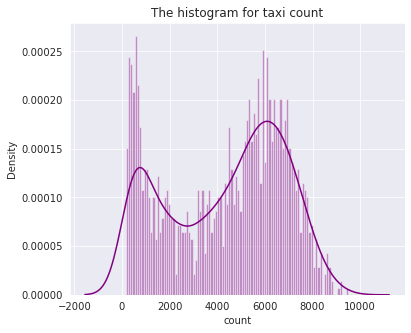

In [58]:
# Frist, it will plot the histogram for count
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
fig.set_size_inches(6,5)
sns.set_style('darkgrid')
sns.distplot(merged_df['count'], bins = 100, color = 'purple')
ax.set(xlabel='count', title='The histogram for taxi count')

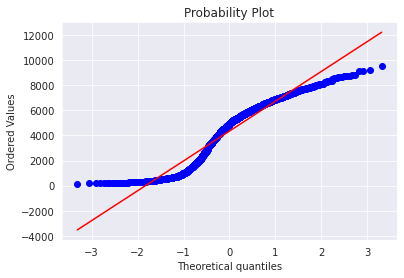

In [59]:
# And plot the Q-Q plot 
from scipy import stats
qq = stats.probplot(merged_df['count'], plot = sns.mpl.pyplot)

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level functi

<AxesSubplot:xlabel='uvindex', ylabel='Density'>

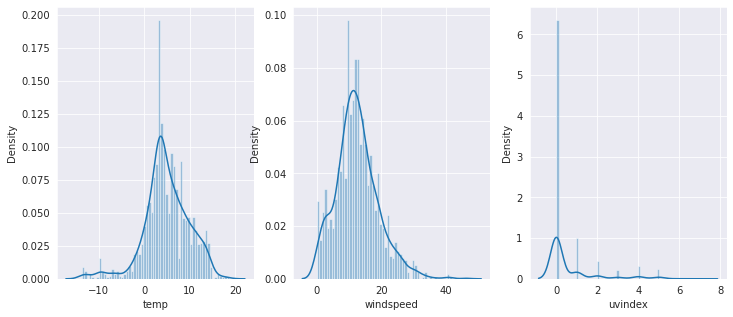

In [60]:
# Plotting histograms and box plots of characteristic variables to observe the distribution of values and outliers

## Histgram 
fig, axes = plt.subplots(1,3)
fig.set_size_inches(12,5)
sns.distplot(merged_df['temp'], bins = 60, ax=axes[0])
sns.distplot(merged_df['windspeed'], bins = 60, ax=axes[1])
sns.distplot(merged_df['uvindex'], bins = 60, ax=axes[2])

<AxesSubplot:xlabel='weekday', ylabel='count'>

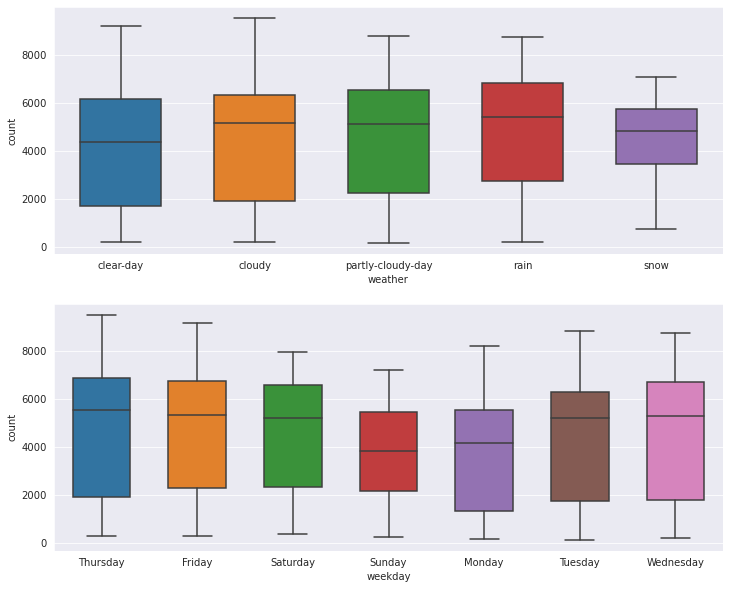

In [62]:
# Boxplot
fig, axes = plt.subplots(2,1)
fig.set_size_inches(12,10)
sns.boxplot(x='weather', y='count', data=merged_df, orient='v',width=0.6, ax=axes[0])
sns.boxplot(x='weekday', y='count', data=merged_df, orient='v',width=0.6, ax=axes[1])

By plotting the histogram and QQ-plot for count, we can see that the distribution of count appears to be bimodal and not normally distributed. Since the interval between the two peaks is not very large, we can do the log transform to make the target variable normally distributed in the data transformation afterwards.      

And it shows that there are no outliers in the characteristic variables through plotting histograms and box plots. In terms of weather, the taxi count is more concentrated in the case of 'SNOW', the average demand for taxis is greater in the case of 'RAIN', and the taxi count is least in the case of 'CLEAR-DAY'. Looking at the week, people have the least average demand for taxis on 'SUNNDAY'.

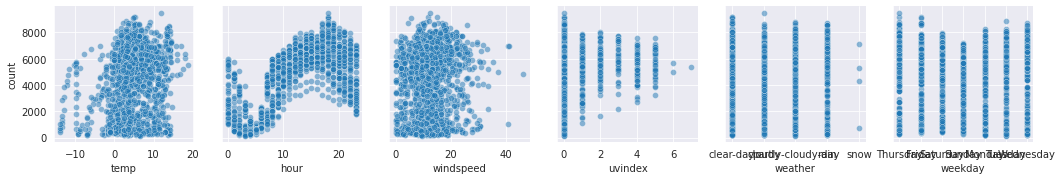

In [64]:
#Plot the correlation plot
sns.pairplot(merged_df, x_vars = ['temp','hour','windspeed','uvindex','weather','weekday'],
 y_vars=['count'], plot_kws={'alpha': 0.5})

The relationship between each characteristic variable and usage is initially observed in the above figure:    
1.'Hour' has a large impact on taxi usage. From 10am - 6pm, taxi usage increases massively.     
2.'Uvidex' also has a strong influence on usage, with the minimum value of 'count' increasing as the uvindex increases. This indicates that when uvidex is enhanced, people will choose cabs more often as a means of travel.

##### **Overall descriptive analysis**

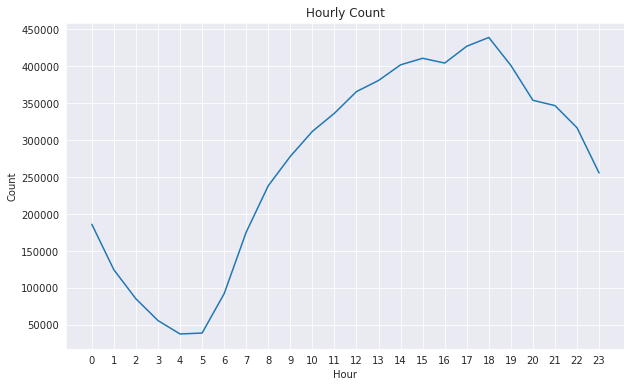

In [43]:
# hourly analysis 
hourly_count = merged_df.groupby('hour')['count'].sum()
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(hourly_count.index, hourly_count.values)
ax.set_xticks(range(24))
ax.set_xlabel('Hour')
ax.set_ylabel('Count')
ax.set_title('Hourly Count')
plt.show()

The line graph of taxi demand for the day shows an increasing trend from 5am, with a peak in demand from 5pm-6pm and a gradual decline from 6pm to early morning.

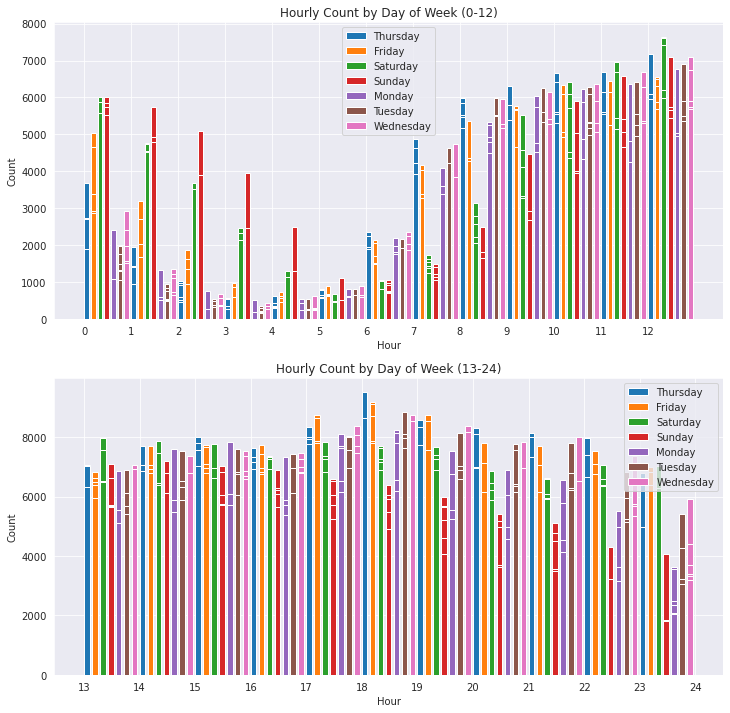

In [44]:
import matplotlib.pyplot as plt
plt.close('all')

# Group data by date, hour and day of the week and count the number of rows in each group
grouped = merged_df.groupby(['date', 'hour', 'weekday'])['count'].sum().reset_index()

group1 = grouped[grouped['hour'] < 13]
group2 = grouped[grouped['hour'] >= 13]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# the first sub-graph（0-12h）
for i, day in enumerate(group1['weekday'].unique()):
    x = group1[group1['weekday'] == day]['hour']
    y = group1[group1['weekday'] == day]['count']
    ax1.bar(x + i / 7, y, width=0.1, align='edge',  label=day)

ax1.set_xticks(range(13))
ax1.set_xlabel('Hour')
ax1.set_ylabel('Count')
ax1.set_title('Hourly Count by Day of Week (0-12)')
ax1.legend()

# the second sub-graph（13-24h）
for i, day in enumerate(group2['weekday'].unique()):
    x = group2[group2['weekday'] == day]['hour'] - 12
    y = group2[group2['weekday'] == day]['count']
    ax2.bar(x + i / 7 + 12, y, width=0.1,align='edge', label=day)

ax2.set_xticks(range(13, 25))
ax2.set_xlabel('Hour')
ax2.set_ylabel('Count')
ax2.set_title('Hourly Count by Day of Week (13-24)')
ax2.legend()

plt.show()

这张图提供了有关每日纽约出租车需求量更详细的信息。例如，在周六周日凌晨时段的乘车量非常高。与其他工作日相比，周五晚上的乘客量更接近非工作日晚上的乘客量，并且周日白天的乘客量明显的低于周一到周六的乘客量。此外，图中还显示了从整体上看，0-12小时的出租车的乘客量要较小于13-24小时。如果假设高乘车率与周末（包括周五晚上）和小班后的社交活动有关，那么周日是外出社交活动的低时段，人们更愿意选择在周五晚上和周六进行社交活动。

This chart provides more detailed information about the daily demand for New York taxis. For example, ridership is very high during the early morning hours on Saturday and Sunday. Friday night ridership is closer to non-working night ridership than other weekdays, and Sunday daytime ridership is significantly lower than Monday through Saturday ridership. In addition, the graph shows that overall, ridership for 0-12 hour taxis is smaller than for 13-24 hours. If it is assumed that high ridership is associated with socialising on weekends (including Friday evenings) and after working, then Sunday is a low time for socialising away from home and people prefer to socialise on Friday evenings and Saturdays.

通过以上分析，我们发现在一周内的变化主要体现在工作日和周末的区别。因此将数据进行处理，在之后分析weekday转换为工作日或者是周末对出租车需求的影响。    
Through the above analysis, we found that the changes during the week are mainly reflected in the difference between weekdays and weekends. Therefore the data are processed and later analyzed for the effect of conversion of weekday to weekday or weekend on cab demand.

In [65]:
#transform to weekday to 'workingday' or 'weekend'
merged_df['weekday'] = merged_df['weekday'].replace({'Sunday': '7', 'Saturday': '6','Friday': '5','Thursday': '4','Wednesday': '3','Tuesday': '2','Monday': '1'})
merged_df['weekday'] = merged_df['weekday'].astype(int)

merged_df_weekday = merged_df.drop(columns = ['weekday'])

def is_weekday(date):
    day_of_week = date.weekday()
    if day_of_week < 5:
        return 'Workingday'
    else:
        return 'Weekend'

merged_df_weekday['day_type'] = merged_df_weekday['date'].apply(is_weekday)
merged_df_weekday.head(100)

,datetime,count,date,hour,temp,windspeed,uvindex,weather,day_type
0,2022-12-01 00:00:00,2746,2022-12-01,0,5.2,24.8,0,clear-day,Workingday
1,2022-12-01 01:00:00,1261,2022-12-01,1,4.5,26.4,0,cloudy,Workingday
2,2022-12-01 02:00:00,670,2022-12-01,2,3.6,21.3,0,clear-day,Workingday
3,2022-12-01 03:00:00,427,2022-12-01,3,3.1,18.2,0,clear-day,Workingday
4,2022-12-01 04:00:00,388,2022-12-01,4,3.0,18.7,0,clear-day,Workingday
...,...,...,...,...,...,...,...,...,...
95,2022-12-04 23:00:00,2795,2022-12-04,23,4.2,9.5,0,clear-day,Weekend
96,2022-12-05 00:00:00,1519,2022-12-05,0,3.6,5.5,0,clear-day,Workingday
97,2022-12-05 01:00:00,654,2022-12-05,1,3.3,9.0,0,clear-day,Workingday
98,2022-12-05 02:00:00,405,2022-12-05,2,2.6,0.0,0,clear-day,Workingday


#### 4.2.2 Data transformation

**one-hot coding for 'icon' and 'weekday'**

In [66]:
encoded_df = pd.get_dummies(merged_df_weekday, columns=['weather','day_type'])
encoded_df.head(5)

,datetime,count,date,hour,temp,windspeed,uvindex,weather_clear-day,weather_cloudy,weather_partly-cloudy-day,weather_rain,weather_snow,day_type_Weekend,day_type_Workingday
0,2022-12-01 00:00:00,2746,2022-12-01,0,5.2,24.8,0,1,0,0,0,0,0,1
1,2022-12-01 01:00:00,1261,2022-12-01,1,4.5,26.4,0,0,1,0,0,0,0,1
2,2022-12-01 02:00:00,670,2022-12-01,2,3.6,21.3,0,1,0,0,0,0,0,1
3,2022-12-01 03:00:00,427,2022-12-01,3,3.1,18.2,0,1,0,0,0,0,0,1
4,2022-12-01 04:00:00,388,2022-12-01,4,3.0,18.7,0,1,0,0,0,0,0,1


In [67]:
encoded_df = encoded_df.drop(columns = ['datetime','date'])

**Log Transformation**

In this project, the target Variable is set to the ‘count’ number. The variable needs to be checked whether there is the outliers or not. And then the logarithmic transformation processing is performed.

In [68]:
# The outlier for the target variable is out - Remove values other than 3 times the variance
data_std = encoded_df[np.abs(encoded_df['count'] - encoded_df['count'].mean())<=(3*encoded_df['count'].std())]
data_std.shape

(1488, 12)

The variable is checked. and there is not the outlier.

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='count', ylabel='Density'>

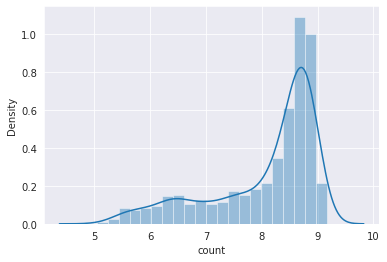

In [69]:
# log transfromation
ylabels = data_std['count']
ylabels_log = np.log(ylabels)
sns.distplot(ylabels_log)

In [70]:
data_std['count_log'] = ylabels_log
data_std = data_std.drop(['count'], axis=1)
data_std

,hour,temp,windspeed,uvindex,weather_clear-day,weather_cloudy,weather_partly-cloudy-day,weather_rain,weather_snow,day_type_Weekend,day_type_Workingday,count_log
0,0,5.2,24.8,0,1,0,0,0,0,0,1,7.917901
1,1,4.5,26.4,0,0,1,0,0,0,0,1,7.139660
2,2,3.6,21.3,0,1,0,0,0,0,0,1,6.507278
3,3,3.1,18.2,0,1,0,0,0,0,0,1,6.056784
4,4,3.0,18.7,0,1,0,0,0,0,0,1,5.961005
...,...,...,...,...,...,...,...,...,...,...,...,...
1483,19,3.3,0.4,0,0,1,0,0,0,0,1,8.792701
1484,20,3.3,11.1,0,0,1,0,0,0,0,1,8.726319
1485,21,2.8,16.2,0,0,1,0,0,0,0,1,8.736007
1486,22,2.1,18.0,0,0,1,0,0,0,0,1,8.542276


Then the dataframe is divided into a training set and a test set, and then the training set is log transformed to improve the accuracy of the model.

In [71]:
# split the train and test data
random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split(data_std.drop(['count_log'], axis=1),data_std['count_log'], test_size=0.25,random_state=random_state_split)

In [72]:
train_df = pd.concat([train_x, train_y], axis = 1)
test_df = pd.concat([test_x, test_y], axis = 1)

# check the shape of training data and testing data
row_train = train_df.shape[0]
row_test = test_df.shape[0]
print('The training dataset has:',row_train,'; The testing dataset has:', row_test)

The training dataset has: 1116 ; The testing dataset has: 372


## 5.Methodology

## 5.1 Correlation Matrix

In [92]:
# Check the correlation
corrDf = train_df.corr()
corrDf

,hour,temp,windspeed,uvindex,weather_clear-day,weather_cloudy,weather_partly-cloudy-day,weather_rain,weather_snow,day_type_Weekend,day_type_Workingday,count_log
hour,1.000000,0.114719,0.052511,0.030600,-0.019831,-0.030693,0.023959,0.041638,0.002157,-0.015565,0.015565,0.664986
temp,0.114719,1.000000,-0.274274,-0.013363,-0.281217,0.101696,0.049227,0.214248,-0.079915,-0.168941,0.168941,0.190377
windspeed,0.052511,-0.274274,1.000000,0.047020,-0.001328,-0.029638,-0.051250,0.094195,0.085388,0.123560,-0.123560,0.068075
uvindex,0.030600,-0.013363,0.047020,1.000000,0.185884,-0.122537,0.054550,-0.160151,-0.025117,0.023966,-0.023966,0.273716
weather_clear-day,-0.019831,-0.281217,-0.001328,0.185884,1.000000,-0.490509,-0.380615,-0.273151,-0.037752,0.099874,-0.099874,-0.047801
weather_cloudy,-0.030693,0.101696,-0.029638,-0.122537,-0.490509,1.000000,-0.353076,-0.253387,-0.035021,0.011228,-0.011228,-0.003279
weather_partly-cloudy-day,0.023959,0.049227,-0.051250,0.054550,-0.380615,-0.353076,1.000000,-0.196618,-0.027175,-0.043207,0.043207,0.038084
weather_rain,0.041638,0.214248,0.094195,-0.160151,-0.273151,-0.253387,-0.196618,1.000000,-0.019502,-0.100793,0.100793,0.026531
weather_snow,0.002157,-0.079915,0.085388,-0.025117,-0.037752,-0.035021,-0.027175,-0.019502,1.000000,-0.034365,0.034365,-0.002405
day_type_Weekend,-0.015565,-0.168941,0.123560,0.023966,0.099874,0.011228,-0.043207,-0.100793,-0.034365,1.000000,-1.000000,0.020103


In [93]:
# Compare the correlation score
corrDf['count_log'].sort_values(ascending=False)

count_log                    1.000000
hour                         0.664986
uvindex                      0.273716
temp                         0.190377
windspeed                    0.068075
weather_partly-cloudy-day    0.038084
weather_rain                 0.026531
day_type_Weekend             0.020103
weather_snow                -0.002405
weather_cloudy              -0.003279
day_type_Workingday         -0.020103
weather_clear-day           -0.047801
Name: count_log, dtype: float64

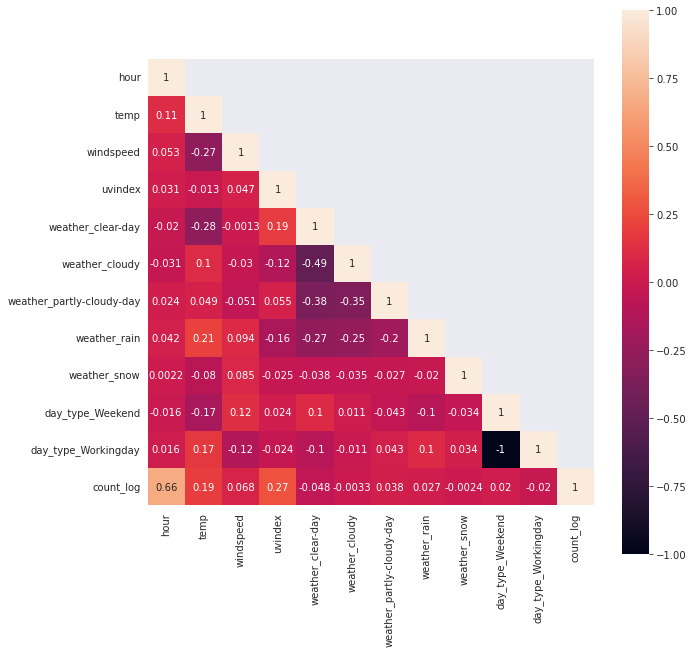

In [94]:
#plot the heatmap of correlation
corrDf
mask = np.array(corrDf)
mask[np.tril_indices_from(mask)]=False
fig = plt.figure(figsize=(10,10))
ax=sns.heatmap(corrDf,mask=mask,annot=True,square=True)

The correlation matrix shows that the factors that are positively correlated with 'count_log' are ranked:hour>uvindex>temp>windspeed>partly cloudy day> rain>weekend.    
The factors that are negatively correlated with 'count_log' are ranked: clear day> cloudy day> weekday.

## 5.2 New York City Taxi Demand Forecast

In this part, it uses linear regression, random forest and Lasso regression for the training dataset to fit the prediction model. And using the test dataset for testing, we compare the accuracy of the models based on the RMSE and R-squred score.

### 5.2.1 Linear Regression

Strong correlations between independent variables such as 'cloudy_day' and 'clear_day' were found to exist through the correlation matrix. This will lead to problems such as model instability, which will reduce the predictive power of the model. To solve this problem, we use VIF test to reduce the effect of multicollinearity.

In [95]:
#vif test
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


def drop_column_using_vif_(train_df, thresh=10):
    while True:
        train_df_with_const = add_constant(train_df)
        vif_train_df = pd.Series(
            [
                variance_inflation_factor(train_df_with_const.values, i)
                for i in range(train_df_with_const.shape[1])
            ],
            name="VIF",
            index=train_df_with_const.columns,
        ).to_frame()
        vif_train_df = vif_train_df.drop("const")
        if vif_train_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_train_df.index[vif_train_df.VIF == vif_train_df.VIF.max()].tolist()[0]
            print("Dropping: {}".format(index_to_drop))
            train_df = train_df.drop(columns=index_to_drop)
        else:
            break
    return train_df

In [75]:
train_df_new = drop_column_using_vif_(train_df.drop('count_log', axis=1))

Dropping: weather_clear-day
Dropping: day_type_Weekend


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [113]:
# train a new model
from sklearn.linear_model import LinearRegression
lr_pc = LinearRegression()
count_col = train_df['count_log']
lr_pc.fit(X=train_df_new, y=count_col)

LinearRegression()

In [115]:
train_df_new.columns

Index(['hour', 'temp', 'windspeed', 'uvindex', 'weather_cloudy',
       'weather_partly-cloudy-day', 'weather_rain', 'weather_snow',
       'day_type_Workingday'],
      dtype='object')

In [114]:
print(lr_pc.coef_)

[ 0.0905862   0.02492779  0.00765751  0.20448627  0.12404682  0.08308998
  0.10869452  0.26330873 -0.09349463]


In [112]:
# measure the model performance
X= test_x.drop(columns = ['weather_clear-day','day_type_Weekend'])
lr_pc.score(X, y=test_y)

0.47188593505824816

In [98]:
from sklearn.metrics import mean_squared_error# make predictions on test set

y_pred_lr = lr_pc.predict(X)

# calculate RMSE
rmse_lr= mean_squared_error(test_df['count_log'], y_pred_lr, squared=False)
print('RMSE:', rmse_lr)

RMSE: 0.6541148183910475


After performing the vif test, the characteristic variables drop the 'icon_clear-day' and 'day_type_Weekday'. Then by fitting a linear regression model, its R-squred is 0.472, and the RMSE is 0.654.In this model, SNOW has the greatest effect on taxi usage, when the weather is 'snow', people will be more willing to choose cabs as a way to travel. Next is 'uvindex', the higher the UV intensity, the more people are willing to choose taxi as a travel mode.

### 5.2.2 Random Forest

In [99]:
#Import random forest regressor model
from sklearn.ensemble import RandomForestRegressor
#Fit the model
RF = RandomForestRegressor(n_estimators=1000, random_state=42)
RF.fit(train_x,train_y)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [101]:
#calculate the score of the random forest model
RF.score(test_x, test_y)

0.9190865299696062

In [ ]:
test_x

,hour,temp,windspeed,uvindex,weather_clear-day,weather_cloudy,weather_partly-cloudy-day,weather_rain,weather_snow,day_type_Weekend,day_type_Workingday
258,18,3.6,14.1,0,0,0,0,1,0,1,0
57,9,12.4,15.2,0,0,0,0,1,0,1,0
225,9,0.8,17.0,2,1,0,0,0,0,1,0
708,12,13.4,10.8,4,1,0,0,0,0,0,1
499,19,3.4,2.0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
884,20,6.3,17.0,0,0,1,0,0,0,0,1
1472,8,2.8,11.0,0,0,0,0,1,0,0,1
91,19,4.6,7.9,0,1,0,0,0,0,1,0
647,23,1.3,13.9,0,0,1,0,0,0,0,1


In [102]:
#make predictions
predictions = RF.predict(test_x)
pred_rf = pd.Series(predictions, index = test_y.index)

# calculate RMSE
rmse_rf= mean_squared_error(test_df['count_log'], pred_rf, squared=False)
print('RMSE:', rmse_rf)

RMSE: 0.2560357054897751


In [103]:
print(RF.feature_importances_)

[8.31917438e-01 5.19988037e-02 2.89452698e-02 1.66141703e-03
 3.98580349e-03 2.96439115e-03 3.12869774e-03 1.50057694e-03
 4.12991924e-05 3.65382669e-02 3.73180355e-02]


By fitting a ranadom forest model, its R-squred is 0.919, and the RMSE is 0.256. By obtaining the importance scores of each feature, it is obtained that hour has the most influence on taxi usage in this model, followed by 'temp' and 'workingday'.

### 5.2.3 XGboost Regression

In [105]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
dtrain = xgb.DMatrix(train_x, label=train_y)
dtest = xgb.DMatrix(test_x, label=test_y)

# Set model parameters
param = {
    'max_depth': 6, 
    'eta': 0.3, 
    'objective': 'reg:squarederror'  
}

# train the model
num_round = 100 
bst = xgb.train(param, dtrain, num_round)

# predict
y_pred_xg = bst.predict(dtest)
# calculate R-squared and RMSE
r_squared_xg = r2_score(test_y, y_pred_xg)
print('R-squared:', r_squared_xg)

rmse_xg = np.sqrt(mean_squared_error(test_y, y_pred_xg))
print('RMSE:', rmse_xg)

R-squared: 0.93161545887446
RMSE: 0.23537974572639986


In [107]:
print(bst.get_score())

{'hour': 951.0, 'temp': 1245.0, 'windspeed': 1031.0, 'uvindex': 108.0, 'weather_clear-day': 109.0, 'weather_cloudy': 83.0, 'weather_partly-cloudy-day': 79.0, 'weather_rain': 50.0, 'weather_snow': 15.0, 'day_type_Weekend': 147.0}


By fitting a Lasso regression model, its R-squred is 0.932, and the RMSE is 0.2335.For the degree of importance of each feature in the model, a higher score indicates that the feature is more important to the model's prediction results. In this model, 'temp' has the greatest effect on the demand for taxi, followed by 'windspeed' and 'hour'.

## 6.Results and discusion

**Summary aboout R-squared and RMSE**

| Method      | R-squared |RMSE |
| ----------- | ----------- |----------- |
| Linear Regression  | 0.47 |0.65 |
| Random Forest |0.919  |0.256|
| XGboost |0.932 |0.235|

By summarizing and comparing the three prediction models of R-squared and RMSE, XGboost model is chosen as a good choice for predicting the taxi usage in New York City. XGboost model as a powerful machine learning method can automatically perform the selection of feature variables and can process high dimensional and non-linear data. The R-squared value is mainly used to evaluate the goodness of fit of the model, with a value closer to 1 indicating a better fit and a value closer to 0 indicating a worse fit. RMSE is mainly used to evaluate the prediction accuracy of the model, and its smaller value means the higher prediction accuracy of the model, and the closer to 0 means the better prediction effect. When choosing the model,we need to combine the two together to analysis. In this model fitting, the R-squared of XGboost model = 0.932 and RMSE = 0.235. Therefore, XGboost model is chosen as the optimal model among the three.

## 7.Conclusion

Taxi plays an important role in the transportation sector in New York City. Analyzing the demand for taxi can better identify peak demand periods, optimize the allocation of cab usage, and improve the city transportation efficiency. In this paper, we use weather conditions and travel time as characteristic variables to first analyze the usage patterns of taxi in New York City in general between December 2022 and January 2023, after which we analyze the usage of cabs specifically at various times of the week, which allows us to discover its peak usage periods. After exploring the data patterns, we conducted a correlation analysis to initially analyze the relationship between each characteristic variable and usage, and found that 'hour' and 'univdex' had a more significant effect on count. After that, linear regression, random forest and XGboost models are built to predict the usage of taxi respectively. With the combined consideration of the model fitting superiority and accuracy, XGboost model is used as a good method for predicting taxi usage in New York City. Therefore travel conditions can predict taxi usage in the New York City. It can help companies and governments to predict taxi usage and make optimization decisions on urban transportation in advance. In this analysis, the model analyzed the usage of yellow taxi that travel in the metropolitan area and did not consider the usage of green taxi that can travel between the suburbs and the city. Therefore, in future analysis, we need to add the data of green cabs so that we can predict the usage of taxi in New York City more accurately.

## 8.Reference